In [107]:
import tensorflow as tf
from tensorflow.contrib.layers import xavier_initializer

%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
import os
from tqdm import tqdm_notebook 
from sklearn.utils import shuffle 

  classname                         img
0       c34  marge_simpson/pic_0601.jpg
1       c34  marge_simpson/pic_0180.jpg
2       c34  marge_simpson/pic_0196.jpg
3       c34  marge_simpson/pic_0698.jpg
4       c34  marge_simpson/pic_0083.jpg
   c0  c17  c30  c32  c34  c8
0   0    0    0    0    1   0
1   0    0    0    0    1   0
2   0    0    0    0    1   0
3   0    0    0    0    1   0
4   0    0    0    0    1   0
(480, 640, 3)
(50, 50, 3)


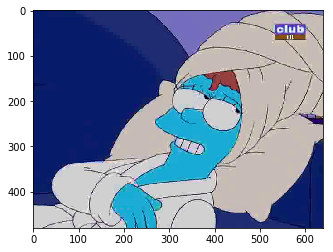

In [108]:
os.chdir('//data/examples/')
simpson_x = pd.read_csv('simpson_preproc/simpson_img_list.csv')
print(simpson_x.head())

img = cv2.imread('simpson_preproc/' + simpson_x.img.iloc[0])
plt.imshow(img)

simpson_x = simpson_x[simpson_x.img.str.contains('simpson')]
simpson_y = pd.get_dummies(simpson_x['classname'])
print(simpson_y.head())
print(img.shape)

img = cv2.resize(img, (50,50))
print(img.shape)

In [109]:
x_train, x_test, y_train, y_test = train_test_split(simpson_x, simpson_y, test_size=0.02, random_state=42)  
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(7128, 2) (146, 2) (7128, 6) (146, 6)


In [110]:
def get_batch_sample(x,y,batch):    
    x = shuffle(x)
    sample_index = x[:batch].index            
    x_sample = x.loc[sample_index]
    y_sample = y.loc[sample_index]
   
    x_batch = None    
    y_batch = y_sample.values  
    for i in x_sample["img"]:        
        dir_img = 'simpson_preproc/' + i
        img = cv2.imread(dir_img)
        img = img / 255
        img = cv2.resize(img, (224,224))
        img = img.reshape((1,224,224,3))
        if x_batch is None:
            x_batch = img
        else:
            x_batch = np.concatenate((x_batch, img))
        
    return x,y,x_batch,y_batch  

def get_batch_sample_test(x):          
    x_batch = None
    for i in x["img"]:        
        dir_img = 'simpson_preproc/' + i
        img = cv2.imread(dir_img)
        img = img / 255
        img = cv2.resize(img,(224,224))
        img = img.reshape((1,224,224,3))        
        if x_batch is None:
            x_batch = img
        else:
            x_batch = np.concatenate((x_batch, img))   
    return x_batch

x_test = get_batch_sample_test(x_test)
y_test = y_test.values

In [111]:
x_train, y_train, x_batch,y_batch = get_batch_sample(x_train, y_train, 30)
print(x_batch.shape)
print(y_batch.shape)

(30, 224, 224, 3)
(30, 6)


In [112]:
def conv(x, out_num, name, kernel_size=(3,3), strides=(1,1)):
    return tf.layers.conv2d(x, out_num, kernel_size=kernel_size, strides=strides, activation=tf.nn.relu, name=name)  

In [113]:
def max_pool(x, name):
    return tf.layers.max_pooling2d(x, pool_size=(2,2), strides=(2,2), name=name)

In [114]:
def dense(x, number, name):
    return tf.layers.dense(x,number, activation=tf.nn.relu,name=name)   

In [115]:
def dense(x, out_num,name):
    return tf.layers.dense(x,out_num, activation=tf.nn.relu,name=name)  

In [116]:
def conv_main(x,label_size):
    print("in", x.shape)
    x = conv(x, 64, "conv1_1")
    x = conv(x, 64, "conv1_2")
    x = max_pool(x, "pool_1") 
    print("1", x.shape)
    x = conv(x, 128, "conv2_1")
    x = conv(x, 128, "conv2_2")
    x = max_pool(x, "pool_2") 
    print("2", x.shape)
    x = conv(x, 256, "conv3_1")
    x = conv(x, 256, "conv3_2")
    x = conv(x, 256, "conv3_3")
    x = max_pool(x, "pool_3") 
    print("3", x.shape)
    x = conv(x, 512, "conv4_1")
    x = conv(x, 512, "conv4_2")
    x = conv(x, 512, "conv4_3")
    x = max_pool(x, "pool_4") 
    print("4", x.shape)
    x = conv(x, 512, "conv5_1")
    x = conv(x, 512, "conv5_2")
    x = conv(x, 512, "conv5_3")
    x = max_pool(x, "pool_5") 
    print("5", x.shape)
    x = tf.layers.flatten(x) 
    x = dense(x,4096, "fc_1_4096")
    x = dense(x,4096, "fc_2_4096")
    x = dense(x,y_batch.shape[1], "fc")        
    return x

In [117]:
tf.reset_default_graph()
x = tf.placeholder(tf.float32, [None, x_batch.shape[1], x_batch.shape[2], x_batch.shape[3]], name='x')
y = tf.placeholder(tf.float32, [None, y_batch.shape[1]], name='y')

fc = conv_main(x, y_batch.shape[1]) 

output = tf.nn.softmax(fc)    
lost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=fc, labels=y), name="lost")    
correct_pred = tf.equal(tf.argmax(fc, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')
update = tf.train.AdamOptimizer().minimize(lost)    
   

in (?, 224, 224, 3)
1 (?, 110, 110, 64)
2 (?, 53, 53, 128)
3 (?, 23, 23, 256)
4 (?, 8, 8, 512)
5 (?, 1, 1, 512)


In [ ]:
epoch = 50
update_per_epoch = 50
batch = 30

train_loss = []
train_acc = []
test_loss = []
test_acc = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in tqdm_notebook(range(epoch)): 
        training_loss = 0
        training_acc = 0
        for j in range(update_per_epoch):
            x_train, y_train, x_batch,y_batch = get_batch_sample(x_train, y_train, 30)
           
            y_pred, training_loss_batch, acc_batch, _ = sess.run([output,lost,accuracy,update], feed_dict = {
                    x: x_batch,
                    y: y_batch            
                })
 
            training_loss += training_loss_batch
            training_acc += acc_batch

        training_loss /= update_per_epoch
        training_acc /= update_per_epoch

        train_loss.append(training_loss)
        train_acc.append(training_acc)

        y_pred, te_loss, te_acc, _ = sess.run([output,lost,accuracy,update], feed_dict = {
                    x: x_test,
                    y: y_test            
                })


        test_loss.append(te_loss)
        test_acc.append(te_acc)
    

In [ ]:
plt.figure(1)
plt.subplot(121)
plt.plot(range(len(train_loss)), train_loss, label='training')
plt.plot(range(len(test_loss)), test_loss, label='validation')
plt.title('Loss')
plt.legend(loc='best')
plt.subplot(122)
plt.plot(range(len(train_acc)), train_acc, label='training')
plt.plot(range(len(test_acc)), test_acc, label='validation')
plt.title('Accuracy')

In [ ]:
saver = tf.train.Saver()
#先指定主路徑
maindir='//home/jovyan/my_data/tf/cnn/'
if not os.path.isdir(maindir):
    os.makedirs(maindir)
    os.chdir(maindir)
else:
    os.chdir(maindir)
#再指定存檔相對路徑存檔
saver.save(sess, "saved_models/model.ckpt")

In [ ]:
'''rerun the graph first:
先回到上面將一開始和graph有關的cell先重新執行一遍，將graph架構先建立起來(這樣讀進來的參數才有對應位置存放)'''

sess = tf.Session()
saver = tf.train.Saver()
saver.restore(sess, "saved_models/model.ckpt")#到我們剛剛存檔的路徑將檔案叫出來，放入graph中對應的參數位置

In [ ]:
print(sess.run(loss, feed_dict={
            input_data:x_batch,
            y_true:y_batch
        }))